In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 18})
import MDAnalysis as mda
from MDAnalysis.analysis.hydrogenbonds.hbond_analysis import HydrogenBondAnalysis
import os
from sklearn.linear_model import LinearRegression
from mpl_toolkits.mplot3d import Axes3D
from scipy.stats import linregress
import warnings
#from tqdm import tqdm  # optional progress bar
warnings.filterwarnings('ignore')
import re
import math

## Using modified MSD with confined water only 

In [17]:
# =====================================
# 1️⃣ Load trajectory and select waters
# =====================================
def load_trajectory(TOPO, TRAJ):
    """Load MD trajectory and select water oxygen atoms."""
    u = mda.Universe(TOPO, TRAJ)
    waters = u.select_atoms("resname SOL and name OW")
    return u, waters


# =====================================
# 2️⃣ Identify initial confined waters
# =====================================
def identify_initial_inside_waters(u, waters, cnt_center, R_tube, z_min, z_max):
    """Find which waters are inside the CNT at frame 0."""
    def inside_CNT(positions):
        x, y, z = positions[:, 0], positions[:, 1], positions[:, 2]
        r = np.sqrt((x - cnt_center[0])**2 + (y - cnt_center[1])**2)
        return np.where((r < R_tube) & (z > z_min) & (z < z_max))[0]

    u.trajectory[500]
    inside_indices = inside_CNT(waters.positions)
    inside_resids = np.unique(waters[inside_indices].resids)
    print(f"{len(inside_resids)} water molecules initially inside CNT")
    return inside_resids


# =====================================
# 3️⃣ Track positions over all frames
# =====================================
def track_water_positions(u, inside_resids):
    """Track 3D positions of selected water molecules across all frames."""
    time = []
    positions = []
    for ts in u.trajectory:
        time.append(ts.time)
        res_pos = []
        for resid in inside_resids:
            res = u.select_atoms(f"resid {resid} and name OW")
            if len(res) == 0:
                continue
            res_pos.append(res.positions[0])
        positions.append(np.array(res_pos))

    positions = np.array(positions)  # (n_frames, n_mols, 3)
    time = np.array(time)
    positions /= 10.0  # Convert Å → nm
    return time, positions


# =====================================
# 4️⃣ Compute radii and z positions
# =====================================
def compute_radial_z_positions(positions, cnt_center, R_tube, z_min, z_max):
    """Compute instantaneous radial and z positions for each molecule."""
    cnt_center_nm = cnt_center / 10.0
    R_tube_nm = R_tube / 10.0
    z_min_nm, z_max_nm = z_min / 10.0, z_max / 10.0

    n_frames, n_mols, _ = positions.shape
    radii = np.zeros((n_frames, n_mols))
    z_positions = np.zeros((n_frames, n_mols))

    for f in range(n_frames):
        x, y, z = positions[f, :, 0], positions[f, :, 1], positions[f, :, 2]
        radii[f, :] = np.sqrt((x - cnt_center_nm[0])**2 + (y - cnt_center_nm[1])**2)
        z_positions[f, :] = z

    return radii, z_positions


# =====================================
# 5️⃣ Compute confined MSD (Einstein-like)
# =====================================
def compute_msd_confined(positions, radii, z_positions, cnt_center, R_tube, z_min, z_max):
    """Compute MSD for confined water molecules that never escape CNT."""
    n_frames, n_mols, _ = positions.shape
    msd_dynamic_3D = np.zeros(n_frames)
    msd_dynamic_z  = np.zeros(n_frames)

    cnt_center_nm = cnt_center / 10.0
    R_tube_nm = R_tube / 10.0
    z_min_nm, z_max_nm = z_min / 10.0, z_max / 10.0
    active_mask = np.ones(n_mols, dtype=bool)

    used_positions_start = []
    used_positions_end   = []

    print("\nComputing MSD (confined water only, permanently removing escaped molecules)...")

    for dt in range(n_frames):
        displacements_3D = []
        displacements_z  = []

        for t0 in range(n_frames - dt):
            inside_both = (
                active_mask &
                (radii[t0] < R_tube_nm) & (radii[t0 + dt] < R_tube_nm) &
                (z_positions[t0] > z_min_nm) & (z_positions[t0] < z_max_nm) &
                (z_positions[t0 + dt] > z_min_nm) & (z_positions[t0 + dt] < z_max_nm)
            )

            if np.any(inside_both):
                # Save positions for visualization
                used_positions_start.append(positions[t0, inside_both])
                used_positions_end.append(positions[t0 + dt, inside_both])

                delta = positions[t0 + dt, inside_both] - positions[t0, inside_both]
                disp2_3D = np.sum(delta**2, axis=1)
                disp2_z  = delta[:, 2]**2
                displacements_3D.append(np.mean(disp2_3D))
                displacements_z.append(np.mean(disp2_z))

            # Deactivate escaped molecules
            escaped_now = (radii[t0 + dt] >= R_tube_nm)
            active_mask[escaped_now] = False

        if displacements_3D:
            msd_dynamic_3D[dt] = np.mean(displacements_3D)
            msd_dynamic_z[dt]  = np.mean(displacements_z)

    if used_positions_start:
        used_positions_start = np.vstack(used_positions_start)
        used_positions_end   = np.vstack(used_positions_end)
    else:
        used_positions_start = np.empty((0, 3))
        used_positions_end   = np.empty((0, 3))

    return msd_dynamic_3D, msd_dynamic_z, used_positions_start, used_positions_end

# ================================================
# 1️⃣ FIT MSD AND COMPUTE DIFFUSION COEFFICIENTS
# ================================================
def fit_diffusion_coefficients(time, msd_dynamic_3D, msd_dynamic_z, fit_start, fit_end):
    """Fit MSD vs time to extract D3D and Dz in nm²/ps and cm²/s."""
    n_points = min(len(time), len(msd_dynamic_3D))
    time = time[:n_points]
    msd_dynamic_3D = msd_dynamic_3D[:n_points]
    msd_dynamic_z  = msd_dynamic_z[:n_points]

    mask = (time >= fit_start) & (time <= fit_end)

    slope_3D, intercept_3D, _, _, _ = linregress(time[mask], msd_dynamic_3D[mask])
    D_3D = slope_3D / 6.0
    D_3D_cm2_s = D_3D * 1e-2

    slope_z, intercept_z, _, _, _ = linregress(time[mask], msd_dynamic_z[mask])
    D_z = slope_z / 2.0
    D_z_cm2_s = D_z * 1e-2

    print("\n--- Confined-water MSD (permanent escape removal) ---")
    print(f"3D D = {D_3D:.3e} nm²/ps  ({D_3D_cm2_s:.3e} cm²/s)")
    print(f"z-axis D = {D_z:.3e} nm²/ps  ({D_z_cm2_s:.3e} cm²/s)")

    return D_3D, D_3D_cm2_s, D_z, D_z_cm2_s, slope_3D, intercept_3D, slope_z, intercept_z, mask


# ================================================
# 2️⃣ SAVE RESULTS TO CSV FILES
# ================================================
def save_diffusion_results(path, time, msd_dynamic_3D, msd_dynamic_z, D_3D_cm2_s, D_z_cm2_s):
    """Save MSD data and diffusion coefficients to CSV."""
    os.makedirs(os.path.join(path, "Figures"), exist_ok=True)

    np.savetxt(
        os.path.join(path, "Figures", "msd_inside_finiteCNT.csv"),
        np.c_[time, msd_dynamic_3D, msd_dynamic_z],
        header="tau_ps, MSD_3D_nm2, MSD_z_nm2",
        delimiter=",", fmt="%.6f"
    )

    np.savetxt(
        os.path.join(path, "Figures", "diffusion_coef_z.csv"),
        np.c_[D_z_cm2_s],
        header="Diffusion_z (cm2/s)",
        delimiter=",", fmt="%.15f"
    )

    np.savetxt(
        os.path.join(path, "Figures", "diffusion_coef_3D.csv"),
        np.c_[D_3D_cm2_s],
        header="Diffusion_3D (cm2/s)",
        delimiter=",", fmt="%.15f"
    )


# ================================================
# 3️⃣ PLOT MSD FITS
# ================================================
def plot_msd(time, msd_dynamic_3D, msd_dynamic_z,
             slope_3D, intercept_3D, slope_z, intercept_z, mask, path):
    """Plot MSD and linear fits."""
    plt.figure(figsize=(6, 4))
    plt.plot(time, msd_dynamic_3D, label='MSD (3D)')
    plt.plot(time[mask], slope_3D * time[mask] + intercept_3D, 'r--', label='Fit (3D)')
    plt.plot(time, msd_dynamic_z, label='MSD (z-axis)')
    plt.plot(time[mask], slope_z * time[mask] + intercept_z, 'g--', label='Fit (z)')
    plt.xlabel('Time (ps)')
    plt.ylabel('MSD (nm²)')
    plt.legend(fontsize=12, loc='upper right')
    plt.title('Dynamic MSD: confined water inside CNT')
    plt.tight_layout()
    plt.savefig(os.path.join(path, "Figures", "MSD_plot.png"), dpi=600, bbox_inches="tight")
    plt.close()


# ================================================
# 4️⃣ PLOT RADIAL AND AXIAL TRAJECTORIES
# ================================================
def plot_radial_axial_positions(time, radii, z_positions, R_tube_nm, z_min_core, z_max_core, path):
    """Plot radial and axial trajectories of water molecules."""
    n_mols = radii.shape[1]
    os.makedirs(os.path.join(path, "Figures"), exist_ok=True)

    idx_sample = np.random.choice(n_mols, size=min(50, n_mols), replace=False)

    # Radial distance plot
    plt.figure(figsize=(6,4))
    for i in idx_sample:
        plt.plot(time, radii[:, i], alpha=0.4)
    plt.axhline(R_tube_nm, color='r', linestyle='--', label='CNT radius')
    plt.xlabel('Time (ps)')
    plt.ylabel('Radial distance (nm)')
    plt.title('Radial position of initially confined waters')
    plt.legend()
    plt.tight_layout()
    plt.savefig(os.path.join(path, "Figures", "Radial_Distance.png"), dpi=600, bbox_inches="tight")
    plt.close()

    # Axial z-position plot
    plt.figure(figsize=(6,4))
    for i in idx_sample:
        plt.plot(time, z_positions[:, i], alpha=0.4)
    plt.axhline(z_min_core, color='r', linestyle='--')
    plt.axhline(z_max_core, color='r', linestyle='--')
    plt.xlabel('Time (ps)')
    plt.ylabel('z position (nm)')
    plt.title('Axial motion of confined waters')
    plt.tight_layout()
    plt.savefig(os.path.join(path, "Figures", "Axial_Distance.png"), dpi=600, bbox_inches="tight")
    plt.close()


# ================================================
# 5️⃣ GENERATE 3D VISUALIZATION OF LAST FRAME
# ================================================
def plot_3D_snapshot(u, waters, cnt_center_nm, R_tube_nm, z_min_nm, z_max_nm,
                     z_min_core, z_max_core, path):
    """Generate 3D scatter visualization of water inside CNT."""
    print("\nGenerating 3D visualization for final frame...")
    u.trajectory[-1]
    pos_last = waters.positions / 10.0
    x, y, z = pos_last[:, 0], pos_last[:, 1], pos_last[:, 2]
    r = np.sqrt((x - cnt_center_nm[0])**2 + (y - cnt_center_nm[1])**2)
    inside_idx = np.where((r < R_tube_nm) & (z_min_core < z) & (z < z_max_core))[0]
    outside_idx = np.setdiff1d(np.arange(len(pos_last)), inside_idx)

    inside_pos = pos_last[inside_idx]
    outside_pos = pos_last[outside_idx]

    fig = plt.figure(figsize=(8,7))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(outside_pos[:,0], outside_pos[:,1], outside_pos[:,2], s=8, c='skyblue', alpha=0.3)
    ax.scatter(inside_pos[:,0], inside_pos[:,1], inside_pos[:,2], s=12, c='red', alpha=0.8)

    theta = np.linspace(0, 2*np.pi, 50)
    z_vals = np.linspace(z_min_nm, z_max_nm, 50)
    theta_grid, z_grid = np.meshgrid(theta, z_vals)
    x_grid = cnt_center_nm[0] + R_tube_nm * np.cos(theta_grid)
    y_grid = cnt_center_nm[1] + R_tube_nm * np.sin(theta_grid)
    ax.plot_surface(x_grid, y_grid, z_grid, color='gray', alpha=0.1, linewidth=0)

    ax.set_xlabel('x (nm)')
    ax.set_ylabel('y (nm)')
    ax.set_zlabel('z (nm)')
    ax.set_box_aspect([1,1,6])
    plt.tight_layout()
    plt.savefig(os.path.join(path, "Figures", "Simulation_model.png"), dpi=600, bbox_inches="tight")
    plt.close()


# ================================================
# 6️⃣ COMPUTE RADIAL DENSITY DISTRIBUTION
# ================================================
def compute_radial_density(u, cnt_center_nm, R_tube_nm, z_min_nm, z_max_nm, path):
    """Compute and plot radial density profiles of water and carbon."""
    def radial_distances(universe, center_nm, selection):
        atoms = universe.select_atoms(selection)
        positions_nm = atoms.positions / 10.0
        r = np.sqrt((positions_nm[:,0] - center_nm[0])**2 +
                    (positions_nm[:,1] - center_nm[1])**2)
        return r

    u.trajectory[-1]
    r_oxy = radial_distances(u, cnt_center_nm, "resname SOL and name OW")
    r_carbon = radial_distances(u, cnt_center_nm, "not resname SOL")

    max_r_plot = R_tube_nm + 0.5
    bins = np.linspace(0, max_r_plot, 100)
    r_centers = 0.5 * (bins[1:] + bins[:-1])
    dr = bins[1] - bins[0]
    Lz = z_max_nm - z_min_nm

    shell_volumes = 2 * np.pi * r_centers * dr * Lz
    counts_oxy, _ = np.histogram(r_oxy, bins=bins)
    counts_carbon, _ = np.histogram(r_carbon, bins=bins)

    rho_oxy = counts_oxy / shell_volumes
    rho_carbon = counts_carbon / shell_volumes
    
    
    plt.figure(figsize=(7,5))
    plt.plot(r_centers, rho_oxy/np.max(rho_oxy), color='C0', lw=2, label='Water O')
    plt.plot(-r_centers, rho_oxy/np.max(rho_oxy), color='C0', lw=2)
    plt.plot(r_centers, rho_carbon/np.max(rho_carbon), color='C1', lw=2, label='CNT C')
    plt.plot(-r_centers, rho_carbon/np.max(rho_carbon), color='C1', lw=2)
    plt.xlabel('Radial distance (nm)')
    plt.ylabel('Normalized density')
    plt.legend()
    plt.tight_layout()
    plt.savefig(os.path.join(path, "Figures", "Radial_density_Last_Frame.png"), dpi=600, bbox_inches="tight")
    plt.close()

    rho_oxy_norm = rho_oxy / np.max(rho_oxy)
    rho_carbon_norm = rho_carbon / np.max(rho_carbon)

    # Create a single table (DataFrame)
    df = pd.DataFrame({
        "r_center": r_centers,
        "rho_oxy": rho_oxy,
        "rho_carbon": rho_carbon,
        "rho_oxy_norm": rho_oxy_norm,
        "rho_carbon_norm": rho_carbon_norm
    })

    # Save to CSV
    df.to_csv(os.path.join(path, "Figures", "density_profiles.csv"), index=False)

# ================================================
# 7️⃣ COMPUTE BULK WATER DENSITY OUTSIDE CNT
# ================================================
def compute_bulk_density(u, cnt_center_nm, R_tube_nm, path):
    """Compute average density of water molecules outside the CNT."""
    waters = u.select_atoms("resname SOL and name OW")
    M_water = 18.01528
    NA = 6.02214076e23
    nm3_to_cm3 = 1e-21

    densities = []
    times = []

    for ts in u.trajectory:
        Lx, Ly, Lz = ts.dimensions[:3]/10
        V_box = Lx * Ly * Lz

        pos = waters.positions / 10.0
        r = np.sqrt((pos[:,0] - cnt_center_nm[0])**2 + (pos[:,1] - cnt_center_nm[1])**2)
        outside_mask = r > R_tube_nm
        N_outside = np.sum(outside_mask)

        V_tube = np.pi * (R_tube_nm**2) * Lz
        V_outside = V_box - V_tube
        mass_g = N_outside * M_water / NA
        rho = mass_g / (V_outside * nm3_to_cm3)
        densities.append(rho)
        times.append(ts.time)

    rho_avg = np.mean(densities)
    print(f"Average bulk water density (outside CNT): {rho_avg:.3f} g/cm³")

    plt.plot(times, densities)
    plt.axhline(rho_avg, color='r', linestyle='--', label=f'Avg = {rho_avg:.3f} g/cm³')
    plt.xlabel("Time (ps)")
    plt.ylabel("Density (g/cm³)")
    plt.legend()
    plt.tight_layout()
    plt.savefig(os.path.join(path, "Figures", "Weight_Density_of_Water.png"), dpi=600, bbox_inches="tight")
    plt.close()


def fit_MSD(path, time, msd3d, msdz, lower_time, upper_time):
    # ---- Choose linear region for fitting (e.g., 100–500 ps) ----
    mask = (time >= lower_time) & (time <= upper_time)
    time_fit = time[mask]
    msd_fit = msd3d[mask]

    # ---- Perform linear regression ----
    slope, intercept, r_value, p_value, std_err = linregress(time_fit, msd_fit)

    # ---- Compute diffusion coefficient ----
    # MSD = 6 * D * t  ->  D = slope / 6
    D_nm2_ps = slope / 6
    D_m2_s = D_nm2_ps * 1e-6  # convert to m^2/s
    D_cm2_s = D_m2_s *1e4

    print(f"Slope: {slope:.4f} nm²/ps")
    print(f"Diffusion coefficient: {D_nm2_ps:.4e} nm²/ps = {D_m2_s:.4e} m²/s = {D_cm2_s:.4e} cm²/s")

    np.savetxt(path + "Figures/" + "diffusion_coef_3D.csv", np.c_[D_cm2_s],
    header="Diffusion_3D Coef in cm2/s",
    delimiter=",", fmt="%.15f")

    ############################################ repeat for 3D ##############################
    mask = (time >= lower_time) & (time <= upper_time)
    time_fit = time[mask]
    msd_fit = msdz[mask]

    # ---- Perform linear regression ----
    slopez, interceptz, r_value, p_value, std_err = linregress(time_fit, msd_fit)

    # ---- Compute diffusion coefficient ----
    # MSD = 6 * D * t  ->  D = slope / 6
    D_nm2_ps = slope / 2
    D_m2_s = D_nm2_ps * 1e-6  # convert to m^2/s
    D_cm2_s = D_m2_s *1e4

    print(f"Slope: {slope:.4f} nm²/ps")
    print(f"Diffusion coefficient: {D_nm2_ps:.4e} nm²/ps = {D_m2_s:.4e} m²/s = {D_cm2_s:.4e} cm²/s")

    #np.savetxt(path + "Figures/" + "diffusion_coef_z.csv", np.c_[D_cm2_s],
    #header="Diffusion_z Coef in cm2/s",
    #delimiter=",", fmt="%.15f")
    
    # # ---- Plot ----
    # fig, ax = plt.subplots(figsize=(7,7))
    # plt.plot(time, msd3d, label='MSD 3D data')
    # plt.plot(time, msdz, label='MSD Z data')
    # #plt.plot(df2[:,0], df2[:,1], linewidth=3, label = '2000ps')
    # plt.plot(time_fit, slope*time_fit + intercept, 'r--', label='Linear fit')
    # plt.plot(time_fit, slopez*time_fit + interceptz, 'r--')
    # plt.xlabel('Time (ps)')
    # plt.ylabel('MSD (nm²)')
    # plt.legend(fontsize=14)
    # plt.title('MSD Fit')
    # #plt.savefig(path + "Figures" + "/MSD_plot.png", dpi=600, bbox_inches="tight")
    # #plt.show()
    return D_cm2_s

def nanotube_properties(n, m, a=0.246):
    """
    Calculate carbon nanotube diameter and chiral angle from arrays n and m.
    
    Parameters
    ----------
    n, m : array-like
        Chiral indices of the carbon nanotubes.
    a : float
        Graphene lattice constant in nanometers (default 0.246 nm).

    Returns
    -------
    diameter : ndarray
        CNT diameters in nanometers.
    angle : ndarray
        Chiral angles in degrees.
    """

    n = np.asarray(n, dtype=float)
    m = np.asarray(m, dtype=float)

    # Diameter formula
    diameter = (a / np.pi) * np.sqrt(n**2 + m**2 + n*m)

    # Chiral angle formula
    angle = np.degrees(np.arctan(np.sqrt(3) * m / (2*n + m)))

    return diameter, angle


## Run Code

In [18]:
#path2 = "../Data/Results_5ns_Sim_Time/"
path2 = "../Data/Reproducibility/"
filenames = os.listdir(path2)
msd_lst = []
for i in range(len(filenames)):
    print(filenames[i])
    path3 = path2 + filenames[i] + '/Figures/msd_inside_finiteCNT.csv'
    df_5ns = pd.read_csv(path3).values
    path4 = path2 + filenames[i] + '/'
    msd = fit_MSD(path4, df_5ns[:,0], df_5ns[:,1], df_5ns[:,2], 100, 1200)
    msd_lst.append(msd)

CNT_n06_m06_L50_350
Slope: 0.0072 nm²/ps
Diffusion coefficient: 1.2058e-03 nm²/ps = 1.2058e-09 m²/s = 1.2058e-05 cm²/s
Slope: 0.0072 nm²/ps
Diffusion coefficient: 3.6175e-03 nm²/ps = 3.6175e-09 m²/s = 3.6175e-05 cm²/s
CNT_n07_m07_L50_290
Slope: 0.0053 nm²/ps
Diffusion coefficient: 8.8446e-04 nm²/ps = 8.8446e-10 m²/s = 8.8446e-06 cm²/s
Slope: 0.0053 nm²/ps
Diffusion coefficient: 2.6534e-03 nm²/ps = 2.6534e-09 m²/s = 2.6534e-05 cm²/s
CNT_n09_m09_L50_262
Slope: 0.0004 nm²/ps
Diffusion coefficient: 6.3207e-05 nm²/ps = 6.3207e-11 m²/s = 6.3207e-07 cm²/s
Slope: 0.0004 nm²/ps
Diffusion coefficient: 1.8962e-04 nm²/ps = 1.8962e-10 m²/s = 1.8962e-06 cm²/s
CNT_n11_m10_L50_248
Slope: 0.0047 nm²/ps
Diffusion coefficient: 7.8366e-04 nm²/ps = 7.8366e-10 m²/s = 7.8366e-06 cm²/s
Slope: 0.0047 nm²/ps
Diffusion coefficient: 2.3510e-03 nm²/ps = 2.3510e-09 m²/s = 2.3510e-05 cm²/s


In [19]:
#path2 = "../Data/Results_5ns_Sim_Time/"
path2 = "../Data/Reproducibility2/"
filenames = os.listdir(path2)
msd_lst2 = []
for i in range(len(filenames)):
    print(filenames[i])
    path3 = path2 + filenames[i] + '/Figures/msd_inside_finiteCNT.csv'
    df_5ns = pd.read_csv(path3).values
    path4 = path2 + filenames[i] + '/'
    msd = fit_MSD(path4, df_5ns[:,0], df_5ns[:,1], df_5ns[:,2], 100, 1200)
    msd_lst2.append(msd)

CNT_n06_m06_L50_350
Slope: 0.0008 nm²/ps
Diffusion coefficient: 1.4053e-04 nm²/ps = 1.4053e-10 m²/s = 1.4053e-06 cm²/s
Slope: 0.0008 nm²/ps
Diffusion coefficient: 4.2158e-04 nm²/ps = 4.2158e-10 m²/s = 4.2158e-06 cm²/s
CNT_n07_m07_L50_290
Slope: 0.0078 nm²/ps
Diffusion coefficient: 1.3002e-03 nm²/ps = 1.3002e-09 m²/s = 1.3002e-05 cm²/s
Slope: 0.0078 nm²/ps
Diffusion coefficient: 3.9007e-03 nm²/ps = 3.9007e-09 m²/s = 3.9007e-05 cm²/s
CNT_n09_m09_L50_262
Slope: 0.0005 nm²/ps
Diffusion coefficient: 8.3517e-05 nm²/ps = 8.3517e-11 m²/s = 8.3517e-07 cm²/s
Slope: 0.0005 nm²/ps
Diffusion coefficient: 2.5055e-04 nm²/ps = 2.5055e-10 m²/s = 2.5055e-06 cm²/s
CNT_n11_m10_L50_248
Slope: 0.0039 nm²/ps
Diffusion coefficient: 6.5153e-04 nm²/ps = 6.5153e-10 m²/s = 6.5153e-06 cm²/s
Slope: 0.0039 nm²/ps
Diffusion coefficient: 1.9546e-03 nm²/ps = 1.9546e-09 m²/s = 1.9546e-05 cm²/s


In [20]:
#path2 = "../Data/Results_5ns_Sim_Time/"
path2 = "../Data/Reproducibility3/"
filenames = os.listdir(path2)
msd_lst3 = []
for i in range(len(filenames)):
    print(filenames[i])
    path3 = path2 + filenames[i] + '/Figures/msd_inside_finiteCNT.csv'
    df_5ns = pd.read_csv(path3).values
    path4 = path2 + filenames[i] + '/'
    msd = fit_MSD(path4, df_5ns[:,0], df_5ns[:,1], df_5ns[:,2], 100, 1200)
    msd_lst3.append(msd)

CNT_n06_m06_L50_350
Slope: 0.0047 nm²/ps
Diffusion coefficient: 7.7644e-04 nm²/ps = 7.7644e-10 m²/s = 7.7644e-06 cm²/s
Slope: 0.0047 nm²/ps
Diffusion coefficient: 2.3293e-03 nm²/ps = 2.3293e-09 m²/s = 2.3293e-05 cm²/s
CNT_n07_m07_L50_290
Slope: 0.0100 nm²/ps
Diffusion coefficient: 1.6658e-03 nm²/ps = 1.6658e-09 m²/s = 1.6658e-05 cm²/s
Slope: 0.0100 nm²/ps
Diffusion coefficient: 4.9974e-03 nm²/ps = 4.9974e-09 m²/s = 4.9974e-05 cm²/s
CNT_n09_m09_L50_262
Slope: 0.0003 nm²/ps
Diffusion coefficient: 5.1069e-05 nm²/ps = 5.1069e-11 m²/s = 5.1069e-07 cm²/s
Slope: 0.0003 nm²/ps
Diffusion coefficient: 1.5321e-04 nm²/ps = 1.5321e-10 m²/s = 1.5321e-06 cm²/s
CNT_n11_m10_L50_248
Slope: 0.0048 nm²/ps
Diffusion coefficient: 8.0627e-04 nm²/ps = 8.0627e-10 m²/s = 8.0627e-06 cm²/s
Slope: 0.0048 nm²/ps
Diffusion coefficient: 2.4188e-03 nm²/ps = 2.4188e-09 m²/s = 2.4188e-05 cm²/s


In [21]:
path2 = "../Data/Results_Loop_Run/"
filenames = os.listdir(path2)
msd_lst4 = []
i = [7,18,35,63]
for j in range(len(i)):
    print(filenames[i[j]])
    path3 = path2 + filenames[i[j]] + '/Figures/msd_inside_finiteCNT.csv'
    df = pd.read_csv(path3).values
    path4 = path2 + filenames[i[j]] + '/'
    msd2 = fit_MSD(path4, df[:,0], df[:,1], df[:,2], 100, 1200)
    msd_lst4.append(msd2)


CNT_n06_m06_L50_350
Slope: 0.0149 nm²/ps
Diffusion coefficient: 2.4777e-03 nm²/ps = 2.4777e-09 m²/s = 2.4777e-05 cm²/s
Slope: 0.0149 nm²/ps
Diffusion coefficient: 7.4332e-03 nm²/ps = 7.4332e-09 m²/s = 7.4332e-05 cm²/s
CNT_n07_m07_L50_290
Slope: 0.0085 nm²/ps
Diffusion coefficient: 1.4102e-03 nm²/ps = 1.4102e-09 m²/s = 1.4102e-05 cm²/s
Slope: 0.0085 nm²/ps
Diffusion coefficient: 4.2306e-03 nm²/ps = 4.2306e-09 m²/s = 4.2306e-05 cm²/s
CNT_n09_m09_L50_262
Slope: 0.0002 nm²/ps
Diffusion coefficient: 3.9686e-05 nm²/ps = 3.9686e-11 m²/s = 3.9686e-07 cm²/s
Slope: 0.0002 nm²/ps
Diffusion coefficient: 1.1906e-04 nm²/ps = 1.1906e-10 m²/s = 1.1906e-06 cm²/s
CNT_n11_m10_L50_248
Slope: 0.0032 nm²/ps
Diffusion coefficient: 5.3805e-04 nm²/ps = 5.3805e-10 m²/s = 5.3805e-06 cm²/s
Slope: 0.0032 nm²/ps
Diffusion coefficient: 1.6141e-03 nm²/ps = 1.6141e-09 m²/s = 1.6141e-05 cm²/s


In [22]:
msd_array = (np.array(msd_lst))
msd_array2 = (np.array(msd_lst2))
msd_array3 = (np.array(msd_lst3))
msd_array4 = (np.array(msd_lst4))
all_values = np.vstack((msd_array.reshape(1,-1), msd_array3.reshape(1,-1), msd_array4.reshape(1,-1)))

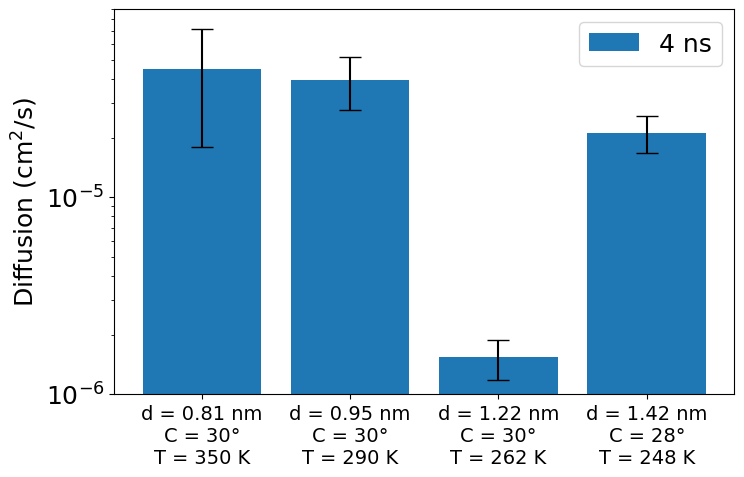

In [23]:
import textwrap
# Compute the mean and standard deviation for each experiment (column-wise)
data = all_values
means = np.mean(data, axis=0)
stds = np.std(data, axis=0, ddof=1)  # ddof=1 gives sample standard deviation

# Create bar plot
x = np.arange(data.shape[1])  # positions for experiments

plt.figure(figsize=(8, 5))
plt.bar(x, means, yerr=stds, capsize=8, label='4 ns')
labels = ["d = 0.81 nm  C = 30°      T = 350 K","d = 0.95 nm C = 30°      T = 290 K","d = 1.22 nm C = 30°      T = 262 K","d = 1.42 nm C = 28°      T = 248 K"]
wrapped_labels = ['\n'.join(textwrap.wrap(label, width=12)) for label in labels]
plt.xticks(x, wrapped_labels, fontsize=14)
plt.ylabel("Diffusion (cm$^{2}$/s)")
#plt.title("Average Diffusion Coefficient with Standard Deviation")
plt.yscale('log')
plt.ylim([1e-6, 9e-5])
plt.legend()
#plt.savefig('../Figures/Reproducibility_4ns.png', dpi=600, bbox_inches="tight")
plt.show()

In [24]:
path2 = "../Data/Results_5ns_Sim_Time/"
#path2 = "../Data/Reproducibility2/"
filenames = os.listdir(path2)
msd_lst5 = []
for i in range(len(filenames)):
    print(filenames[i])
    path3 = path2 + filenames[i] + '/Figures/msd_inside_finiteCNT.csv'
    df_5ns = pd.read_csv(path3).values
    path4 = path2 + filenames[i] + '/'
    msd = fit_MSD(path4, df_5ns[:,0], df_5ns[:,1], df_5ns[:,2], 100, 1200)
    msd_lst5.append(msd)

CNT_n06_m06_L50_200
Slope: 0.0000 nm²/ps
Diffusion coefficient: 2.1576e-06 nm²/ps = 2.1576e-12 m²/s = 2.1576e-08 cm²/s
Slope: 0.0000 nm²/ps
Diffusion coefficient: 6.4727e-06 nm²/ps = 6.4727e-12 m²/s = 6.4727e-08 cm²/s
CNT_n07_m07_L50_290
Slope: 0.0113 nm²/ps
Diffusion coefficient: 1.8902e-03 nm²/ps = 1.8902e-09 m²/s = 1.8902e-05 cm²/s
Slope: 0.0113 nm²/ps
Diffusion coefficient: 5.6705e-03 nm²/ps = 5.6705e-09 m²/s = 5.6705e-05 cm²/s
CNT_n09_m09_L50_262
Slope: 0.0005 nm²/ps
Diffusion coefficient: 8.9924e-05 nm²/ps = 8.9924e-11 m²/s = 8.9924e-07 cm²/s
Slope: 0.0005 nm²/ps
Diffusion coefficient: 2.6977e-04 nm²/ps = 2.6977e-10 m²/s = 2.6977e-06 cm²/s
CNT_n10_m10_L50_283
Slope: 0.0050 nm²/ps
Diffusion coefficient: 8.3345e-04 nm²/ps = 8.3345e-10 m²/s = 8.3345e-06 cm²/s
Slope: 0.0050 nm²/ps
Diffusion coefficient: 2.5004e-03 nm²/ps = 2.5004e-09 m²/s = 2.5004e-05 cm²/s


In [25]:
path2 = "../Data/Reproducibility_5ns/"
#path2 = "../Data/Reproducibility2/"
filenames = os.listdir(path2)
msd_lst6 = []
for i in range(len(filenames)):
    print(filenames[i])
    path3 = path2 + filenames[i] + '/Figures/msd_inside_finiteCNT.csv'
    df_5ns = pd.read_csv(path3).values
    path4 = path2 + filenames[i] + '/'
    msd = fit_MSD(path4, df_5ns[:,0], df_5ns[:,1], df_5ns[:,2], 100, 1200)
    msd_lst6.append(msd)

CNT_n06_m06_L50_350
Slope: 0.0078 nm²/ps
Diffusion coefficient: 1.3055e-03 nm²/ps = 1.3055e-09 m²/s = 1.3055e-05 cm²/s
Slope: 0.0078 nm²/ps
Diffusion coefficient: 3.9165e-03 nm²/ps = 3.9165e-09 m²/s = 3.9165e-05 cm²/s
CNT_n07_m07_L50_290
Slope: 0.0059 nm²/ps
Diffusion coefficient: 9.8547e-04 nm²/ps = 9.8547e-10 m²/s = 9.8547e-06 cm²/s
Slope: 0.0059 nm²/ps
Diffusion coefficient: 2.9564e-03 nm²/ps = 2.9564e-09 m²/s = 2.9564e-05 cm²/s
CNT_n09_m09_L50_262
Slope: 0.0003 nm²/ps
Diffusion coefficient: 5.2400e-05 nm²/ps = 5.2400e-11 m²/s = 5.2400e-07 cm²/s
Slope: 0.0003 nm²/ps
Diffusion coefficient: 1.5720e-04 nm²/ps = 1.5720e-10 m²/s = 1.5720e-06 cm²/s
CNT_n11_m10_L50_248
Slope: 0.0061 nm²/ps
Diffusion coefficient: 1.0162e-03 nm²/ps = 1.0162e-09 m²/s = 1.0162e-05 cm²/s
Slope: 0.0061 nm²/ps
Diffusion coefficient: 3.0486e-03 nm²/ps = 3.0486e-09 m²/s = 3.0486e-05 cm²/s


In [26]:
path2 = "../Data/Reproducibility_5ns_2/"
#path2 = "../Data/Reproducibility2/"
filenames = os.listdir(path2)
msd_lst7 = []
for i in range(len(filenames)):
    print(filenames[i])
    path3 = path2 + filenames[i] + '/Figures/msd_inside_finiteCNT.csv'
    df_5ns = pd.read_csv(path3).values
    path4 = path2 + filenames[i] + '/'
    msd = fit_MSD(path4, df_5ns[:,0], df_5ns[:,1], df_5ns[:,2], 100, 1200)
    msd_lst7.append(msd)

CNT_n06_m06_L50_350
Slope: 0.0051 nm²/ps
Diffusion coefficient: 8.4926e-04 nm²/ps = 8.4926e-10 m²/s = 8.4926e-06 cm²/s
Slope: 0.0051 nm²/ps
Diffusion coefficient: 2.5478e-03 nm²/ps = 2.5478e-09 m²/s = 2.5478e-05 cm²/s
CNT_n07_m07_L50_290
Slope: 0.0037 nm²/ps
Diffusion coefficient: 6.2102e-04 nm²/ps = 6.2102e-10 m²/s = 6.2102e-06 cm²/s
Slope: 0.0037 nm²/ps
Diffusion coefficient: 1.8631e-03 nm²/ps = 1.8631e-09 m²/s = 1.8631e-05 cm²/s
CNT_n09_m09_L50_262
Slope: 0.0003 nm²/ps
Diffusion coefficient: 4.6958e-05 nm²/ps = 4.6958e-11 m²/s = 4.6958e-07 cm²/s
Slope: 0.0003 nm²/ps
Diffusion coefficient: 1.4087e-04 nm²/ps = 1.4087e-10 m²/s = 1.4087e-06 cm²/s
CNT_n11_m10_L50_248
Slope: 0.0038 nm²/ps
Diffusion coefficient: 6.3474e-04 nm²/ps = 6.3474e-10 m²/s = 6.3474e-06 cm²/s
Slope: 0.0038 nm²/ps
Diffusion coefficient: 1.9042e-03 nm²/ps = 1.9042e-09 m²/s = 1.9042e-05 cm²/s


In [27]:
msd_array5 = (np.array(msd_lst5))
msd_array6 = (np.array(msd_lst6))
msd_array7 = (np.array(msd_lst7))
all_values = np.vstack((msd_array5.reshape(1,-1), msd_array6.reshape(1,-1), msd_array7.reshape(1,-1)))
#all_values = msd_array5

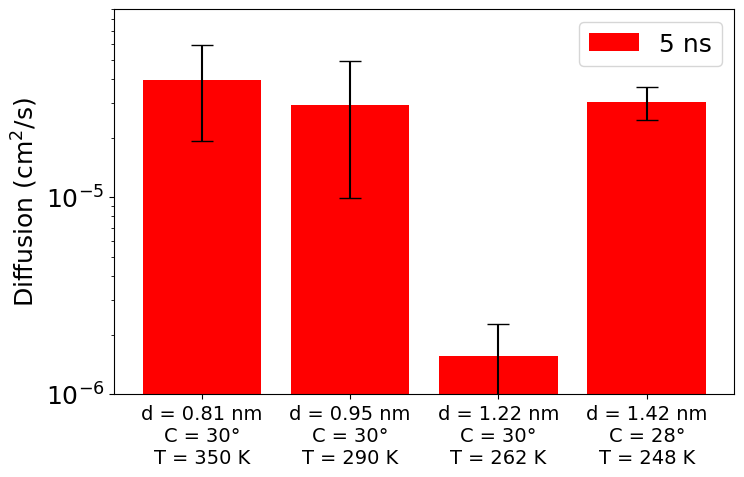

In [28]:
import textwrap
# Compute the mean and standard deviation for each experiment (column-wise)
data = all_values
means_5ns = np.mean(data, axis=0)
stds = np.std(data, axis=0, ddof=1)  # ddof=1 gives sample standard deviation

# Create bar plot
x = np.arange(data.shape[1])  # positions for experiments

plt.figure(figsize=(8, 5))
#plt.bar(x, means_5ns, yerr=stds, capsize=8)
plt.bar(x, msd_array6, yerr=stds, capsize=8, color='red', label='5 ns')
labels = ["d = 0.81 nm  C = 30°      T = 350 K","d = 0.95 nm C = 30°      T = 290 K","d = 1.22 nm C = 30°      T = 262 K","d = 1.42 nm C = 28°      T = 248 K"]
wrapped_labels = ['\n'.join(textwrap.wrap(label, width=12)) for label in labels]
plt.xticks(x, wrapped_labels, fontsize=14)
plt.ylabel("Diffusion (cm$^{2}$/s)")
#plt.title("Average Diffusion Coefficient with Standard Deviation")
plt.yscale('log')
plt.ylim([1e-6, 9e-5])
plt.legend()
#plt.savefig('../Figures/Reproducibility_5ns.png', dpi=600, bbox_inches="tight")
plt.show()

CNT_n06_m06_L50_350
CNT_n07_m07_L50_290
CNT_n09_m09_L50_262
CNT_n11_m10_L50_248
CNT_n08_m06_L50_290
CNT_n09_m07_L50_400
CNT_n11_m10_L50_379
CNT_n12_m10_L50_331
CNT_n09_m09_L50_207
CNT_n12_m10_L50_379
CNT_n11_m11_L50_200
CNT_n07_m06_L50_228


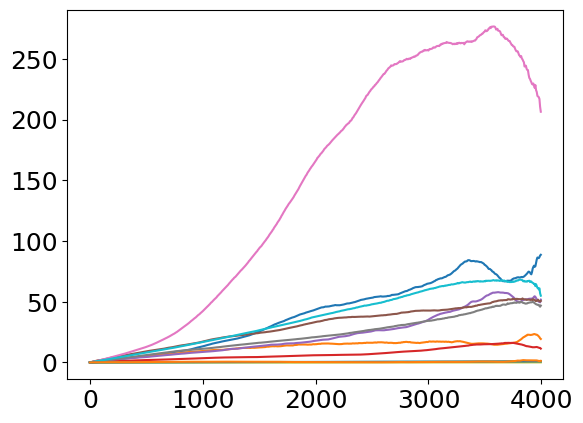

In [29]:
path2 = "../Data/Results_Loop_Run/"
filenames = os.listdir(path2)
msd_lst2 = []
i = [7,18,35,63, 23, 32, 65, 76, 34, 78, 66, 13]
for j in range(len(i)):
    print(filenames[i[j]])
    path3 = path2 + filenames[i[j]] + '/Figures/msd_inside_finiteCNT.csv'
    df = pd.read_csv(path3).values
    plt.plot(df[:,0], df[:,2])


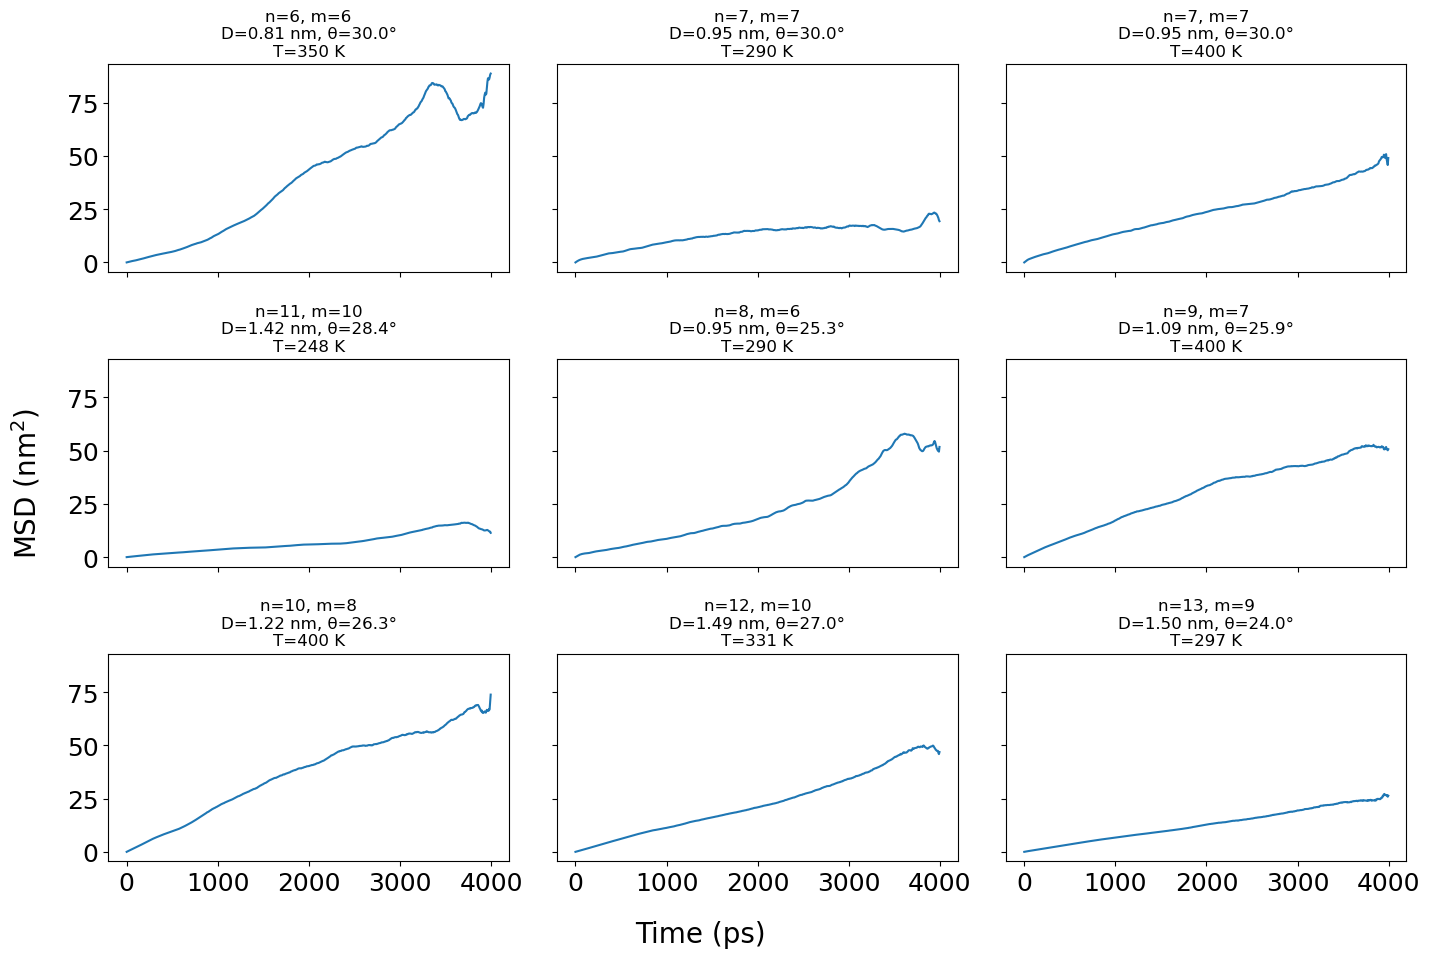

In [ ]:
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


path2 = "../Data/Results_Loop_Run/"
filenames = os.listdir(path2)
indices = [7, 18, 21, 63, 23, 32, 45, 76, 90]

# Create subpots
fig, axes = plt.subplots(3, 3, figsize=(15, 10), sharex=True, sharey=True)
axes = axes.flatten()

# Regex to extract n, m, L, T from filename
pattern = r"CNT_n(\d+)_m(\d+)_L(\d+)_([0-9]+)"

for idx, file_index in enumerate(indices):
    filename = filenames[file_index]

    # ---- Extract parameters from filename ----
    match = re.search(pattern, filename)
    if match:
        n_str, m_str, L_str, T_str = match.groups()
        n = int(n_str)
        m = int(m_str)
        T = int(T_str)

        # Compute CNT properties
        diameter, angle = nanotube_properties(n, m)
        diameter = float(diameter)
        angle = float(angle)

        # Create title text
        title = (
            f"n={n}, m={m}\n"
            f"D={diameter:.2f} nm, θ={angle:.1f}°\n"
            f"T={T} K"
        )
    else:
        title = filename  # fallback if unexpected format

    # ---- Load CSV ----
    path3 = os.path.join(path2, filename, "Figures/msd_inside_finiteCNT.csv")
    df = pd.read_csv(path3).values

    # ---- Plot into the correct subplot ----
    ax = axes[idx]
    ax.plot(df[:,0], df[:,2])
    ax.set_title(title, fontsize=12)

# Shared labels
fig.text(0.5, 0.04, 'Time (ps)', ha='center', fontsize=20)
fig.text(0.04, 0.5, 'MSD (nm$^{2}$)', va='center', rotation='vertical', fontsize=20)

plt.tight_layout(rect=[0.06, 0.06, 1, 1])
#plt.savefig('../Figures/Reproducibility_MSD.png', dpi=600, bbox_inches="tight")
plt.show()
